 #### (2) 인지검사별 피처 분석

 - **반응시간/정확도 분포**
   - A1/A2(속도·정지 예측), A3(주의 전환), A4(Stroop), B3(신호등), B4(Flanker) 등 
 	핵심 과제의 `*_rt_mean`, `*_rt_std`, `*_acc_*` 분포 확인
   - 이상치(outlier) 후보(극단적 반응시간, 지나치게 낮은 정확도)를 확인하여 
 	전처리/모델링에서의 처리 방식을 검토

 - **조건 간 차이 및 log-ratio**
   - Stroop/Flanker 계열
 	- 조건별 평균/정확도 차이 및 log-ratio(`A4_stroop_*`, `B4_flanker_*`)를 통해 
   	간섭 효과 크기가 어느 정도 범위에서 움직이는지 확인
   - 주의 전환/시야각 계열
 	- `A3_valid_acc` vs `A3_invalid_acc`, `B1/B2_change_acc` vs `nonchange_acc` 등 
   	조건별 난이도 차이가 일관되게 나타나는지 검토

 - **Speed–Accuracy 및 CV**
    - `*_speed_acc_tradeoff`, `*_rt_cv` 분포를 통해 
    	- 빠른 대신 오류가 많은 유형
        - 느리지만 정확한 유형 
    - 등을 구분할 수 있는지, 값 범위가 안정적인지 확인

 #### (3) 히스토리·Delta·상관 분석

 - **PK 히스토리**
   - `pk_hist_A_count`, `pk_hist_B_count`, `pk_hist_gap_from_prev`를 이용해 반복 검사 빈도가 높은 PK의 인지지표가 시간이 지날수록 안정화되는지
 	- 일정 간격 이후 검사에서 급격한 성능 변화가 나타나는지 
 	등을 탐색

 - **Delta(B-only)**
   - `delta_B*_…` 피처의 분포를 확인하여 평균적으로 변화가 0 근처에 몰려 있는지
 	- 특정 과제에서만 변화폭이 큰지 
 	등을 파악하고, 노이즈로 볼 것인지 의미 있는 신호로 볼 것인지 판단

 - **상관 구조**
   - 반응시간·정확도·log-ratio·히스토리·Delta 피처 간 상관계수 행렬을 통해 피처 그룹 간 중복/보완 관계를 파악
   - 트리 기반 모델의 특성상 강한 상관이 존재해도 필수적으로 제거하지는 않되, 도메인 해석이 불명확한 피처는 중요도가 낮을 경우 정리 대상 후보로 고려



In [68]:
import os
import pandas as pd

BASE_DIR = "./data"
MODEL_SAVE_DIR = "./model"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

try:
    train_meta = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
    train_A_raw = pd.read_csv(os.path.join(BASE_DIR, "train", "A.csv"))
    train_B_raw = pd.read_csv(os.path.join(BASE_DIR, "train", "B.csv"))
except FileNotFoundError:
    print(f"경고: '{BASE_DIR}' 경로에 파일이 없습니다. data 폴더에 원본 데이터를 넣어주세요.")
    raise
print("데이터 로드 완료:", train_meta.shape, train_A_raw.shape, train_B_raw.shape)

display(train_meta.head())
display(train_A_raw.head())
display(train_B_raw.head())

데이터 로드 완료: (944767, 3) (647241, 37) (297526, 31)


,Test_id,Test,Label
0,0xE3EDFEA7DB8FF2606A19628967674BA957FB4BD58549...,A,0
1,0xDA572847455702C04D71C54677413CB8E31944B99289...,A,0
2,0xD5BB9FA4D3BC42EE494BD670F004564CB04A0DF8F819...,B,0
3,0x59D17D1C537B5FDE6622A9CB0A4192529CB4BD8D5422...,A,0
4,0x23005DA8BB4C84E1363A44A4248987798F3EAD4C58D3...,A,0


,Test_id,Test,PrimaryKey,Age,TestDate,A1-1,A1-2,A1-3,A1-4,A2-1,...,A5-3,A6-1,A7-1,A8-1,A8-2,A9-1,A9-2,A9-3,A9-4,A9-5
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,"2,2,1,2,1,2,1,1,2,1,2,1,1,2,1,2,2,1","1,3,3,2,3,3,2,2,3,3,2,1,2,1,1,1,2,1","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","29,33,56,64,5,-51,44,-1,0,31,30,5,67,33,43,21,...","1,1,2,3,1,2,2,3,3,1,1,3,2,2,1,2,3,3",...,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",13,15,0,1,4,16,0,5,7
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,"2,2,1,2,2,1,1,1,2,2,1,2,1,1,2,1,2,1","3,2,2,1,1,3,1,1,2,3,2,1,3,1,2,3,3,2","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","76,1,27,25,41,34,-24,7,18,85,-18,-21,31,-7,18,...","2,3,3,1,2,2,3,2,3,1,2,3,1,3,2,1,1,1",...,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",11,11,9,0,1,3,0,0,4
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,"1,1,2,1,2,2,2,2,1,2,1,1,1,1,1,2,2,2","2,3,3,1,1,2,1,1,3,2,1,2,2,3,1,2,3,3","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","-1,22,0,-37,-21,7,-34,-21,-79,-26,-80,-23,-63,...","1,1,3,2,3,2,1,1,1,1,3,2,2,2,2,3,3,3",...,"0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",12,16,2,2,2,5,0,4,4
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,"2,2,2,2,1,2,1,1,2,2,1,1,1,1,2,1,2,1","1,3,3,1,2,2,2,3,2,3,2,1,1,1,2,3,1,3","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","-60,25,-25,-34,-40,-60,-46,-79,-77,-51,-80,-62...","1,2,2,3,1,1,2,2,3,1,3,2,1,3,3,3,2,1",...,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",11,15,0,0,0,0,2,0,2
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,"2,2,1,1,2,1,1,2,1,1,1,1,2,2,1,2,2,2","1,3,1,3,2,1,1,1,3,2,2,2,2,3,3,3,2,1","0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0","-42,-77,-33,-3,-38,-58,-88,-4,-28,-58,-40,-29,...","1,3,3,2,2,2,3,1,3,1,1,2,1,3,1,2,3,2",...,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",11,8,0,2,9,16,1,21,4


,Test_id,Test,PrimaryKey,Age,TestDate,B1-1,B1-2,B1-3,B2-1,B2-2,...,B9-2,B9-3,B9-4,B9-5,B10-1,B10-2,B10-3,B10-4,B10-5,B10-6
0,0x787FBE5FFAAA39906462AF8C91D443BD00378C48B7B9...,B,0x787FBE5FFAAA39906462AF8C91D443BD00378C48B7B9...,60b,201602,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1","0,0.03798499,0,0.5811322,0,0,0.5803714,1.00910...","3,1,4,1,3,4,1,1,3,1,4,1,1,1,3,4","1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1","0.8907053,0,0,0,0,1.040678,0.6199818,0,0,0.657...",...,0,0,35,1,20,0,3,57,7,15
1,0x7DB36D7A524A672BA5755791ACE73A5BC4C2B7BBF306...,B,0x7DB36D7A524A672BA5755791ACE73A5BC4C2B7BBF306...,60b,201602,"1,2,2,2,2,2,1,2,2,2,1,1,1,1,1,1","0,0,0,0.1280282,0,0,0.9760087,0.03197882,0,0.0...","4,4,3,1,4,2,1,1,4,1,4,1,3,3,1,1","1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",...,0,0,35,2,19,1,1,59,10,19
2,0x7A452245E96D81402DFE424FA86C99CBB4F619F8E0A5...,B,0x7A452245E96D81402DFE424FA86C99CBB4F619F8E0A5...,70a,201602,"1,2,2,1,1,1,1,1,2,1,1,1,1,1,1,1","0.5967258,0,0,0,0,0,0.7050578,0.6730202,0,0.83...","1,4,4,2,4,3,1,1,4,1,1,3,1,3,4,1","2,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1","0,0.7690769,0,0,0.7381148,0,0,0.9290089,0,0,0....",...,0,0,35,0,18,2,0,60,5,19
3,0x03D41789BB982E80E41D777A45F3AC3A0A46A56BFF6B...,B,0x03D41789BB982E80E41D777A45F3AC3A0A46A56BFF6B...,60b,201602,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1","0,0,0,0.6738921,0,0.5439928,0.5342392,0.424049...","4,4,4,1,4,1,1,1,3,1,4,1,4,4,1,1","1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1","0.5470542,0,0,0,0,0.5041592,0.542075,0,0,0.740...",...,0,0,35,6,19,1,2,58,4,20
4,0xF87E0D874A96EBB7902314E227D4065422D1F2D2AEC1...,B,0xF87E0D874A96EBB7902314E227D4065422D1F2D2AEC1...,60b,201602,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1","0,0.3119312,0,0.03894603,0,0,0.03889565,0.0389...","4,1,3,1,4,3,1,1,4,1,3,1,1,1,4,3","1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1","0.4689675,0,0,0.03903218,0,0.7800297,0,0.54600...",...,0,1,34,0,20,0,0,60,14,20


## 1. 인지검사별 피처 분석

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_feather("./data/all_train_data.feather")
for i in df.columns:
    print(i)

Test_id
Test_x
Label
Test_y
PrimaryKey
Age
TestDate
Age_num
Year
Month
A1_rt_mean
A1_rt_std
A1_rt_left
A1_rt_right
A1_rt_slow
A1_rt_norm
A1_rt_fast
A1_acc_slow
A1_acc_norm
A1_acc_fast
A2_rt_mean
A2_rt_std
A2_rt_slow_c1
A2_rt_norm_c1
A2_rt_fast_c1
A2_rt_slow_c2
A2_rt_norm_c2
A2_rt_fast_c2
A2_acc_slow
A2_acc_norm
A2_acc_fast
A3_valid_acc
A3_invalid_acc
A3_rt_mean
A3_rt_std
A3_rt_small
A3_rt_big
A3_rt_left
A3_rt_right
A4_rt_mean
A4_rt_std
A4_rt_congruent
A4_rt_incongruent
A4_acc_congruent
A4_acc_incongruent
A5_acc_nonchange
A5_acc_pos_change
A5_acc_color_change
A5_acc_shape_change
A6_correct_count
A7_correct_count
YearMonthIndex
A1_speed_acc_tradeoff
A2_speed_acc_tradeoff
A4_speed_acc_tradeoff
A1_rt_cv
A2_rt_cv
A3_rt_cv
A4_rt_cv
A1_rt_speed_log_ratio
A1_acc_speed_log_ratio
A2_rt_speed_log_ratio_c1
A2_acc_speed_log_ratio
A3_rt_size_log_ratio
A3_acc_attention_log_ratio
A4_stroop_rt_log_ratio
A4_stroop_acc_log_ratio
A5_acc_pos_log_ratio
A5_acc_color_log_ratio
B1_task1_acc
B1_rt_mean
B1_rt_st

### 1. 반응시간/정확도 분포

In [3]:
# 분석 대상 패턴
RT_PATTERNS = ["_rt_mean", "_rt_std"]
ACC_PATTERNS = ["A4_acc_congruent", "A4_acc_incongruent", "B4_congruent_acc", "B4_incongruent_acc"]

# 특정 prefix(예: A1, A2, A3, A4, B3, B4 등)가 들어간 핵심 과제만 선택
TARGET_PREFIX = ("A1_", "A2_", "A3_", "A4_", "B3_", "B4_")

In [4]:
def select_columns(patterns):
    cols = []
    for col in df.columns:
        if col.startswith(TARGET_PREFIX):
            if any(p in col for p in patterns):
                cols.append(col)
    return cols

In [5]:
rt_cols = select_columns(RT_PATTERNS)
acc_cols = select_columns(ACC_PATTERNS)

print("RT 피처 개수:", len(rt_cols))
print("ACC 피처 개수:", len(acc_cols))
acc_cols

RT 피처 개수: 12
ACC 피처 개수: 4


['A4_acc_congruent',
 'A4_acc_incongruent',
 'B4_congruent_acc',
 'B4_incongruent_acc']

#### 1-1. A1/A2(속도·정지 예측), A3(주의 전환), A4(Stroop), B3(신호등), B4(Flanker) 등 핵심 과제의 `*_rt_mean`, `*_rt_std`, `*_acc_*` 분포 확인

In [6]:
# ---------------------------- #
# 1) 요약통계 출력 함수
# ---------------------------- #
def summary_stats(cols):
    display(df[cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

print("\n[RT Summary Statistics]")
summary_stats(rt_cols)

print("\n[ACC Summary Statistics]")
summary_stats(acc_cols)


[RT Summary Statistics]


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
A1_rt_mean,647241.0,-9.244519,64.835905,-727.777778,-150.611111,-92.055556,-42.111111,-14.944444,20.555556,84.000000,205.111111,654.722222
A1_rt_std,647241.0,54.097523,53.727748,9.342588,18.777959,22.290728,28.544096,37.627028,51.905779,178.827353,297.224483,738.513489
A2_rt_mean,647240.0,-33.013742,38.621837,-548.944444,-127.833333,-85.000000,-55.888889,-28.333333,-10.833333,17.055556,64.500000,999.000000
A2_rt_std,647240.0,60.330976,58.784138,0.000000,22.160748,23.203940,33.898769,43.898628,56.900796,236.185225,319.131915,770.902589
A3_rt_mean,647240.0,973.398024,242.566276,297.437500,628.843750,684.406250,807.562500,899.906250,1117.351562,1451.937500,1674.593750,2501.343750
A3_rt_std,647240.0,322.236495,96.913304,2.779494,156.700207,197.068550,241.801905,311.281644,387.126559,495.731797,573.606262,1025.981035
A4_rt_mean,647241.0,634.780203,85.169331,136.687500,498.100000,528.000000,572.487500,619.250000,680.800000,788.025000,891.577500,3002.075000
A4_rt_std,647241.0,97.425931,53.969108,2.131754,48.320937,57.199485,67.525731,84.088620,105.411574,185.723233,323.164302,1233.563580
B3_rt_mean,297523.0,0.811799,0.555448,0.000000,0.522742,0.575908,0.657317,0.718480,0.795242,1.089930,3.811414,10.000000
B3_rt_std,297523.0,0.229678,0.653592,0.000000,0.030859,0.040677,0.062526,0.085061,0.116389,0.418524,4.146475,4.732296



[ACC Summary Statistics]


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
A4_acc_congruent,647241.0,0.990402,0.021544,0.0,0.925000,0.950000,0.975000,1.000000,1.0,1.0,1.0,1.0
A4_acc_incongruent,647241.0,0.982077,0.030537,0.0,0.875000,0.925000,0.975000,1.000000,1.0,1.0,1.0,1.0
B4_congruent_acc,297523.0,0.949837,0.144279,0.0,0.166667,0.700000,0.966667,1.000000,1.0,1.0,1.0,1.0
B4_incongruent_acc,297523.0,0.913701,0.165497,0.0,0.100000,0.566667,0.933333,0.966667,1.0,1.0,1.0,1.0


RT mean 피처 수: 6
RT std 피처 수: 6


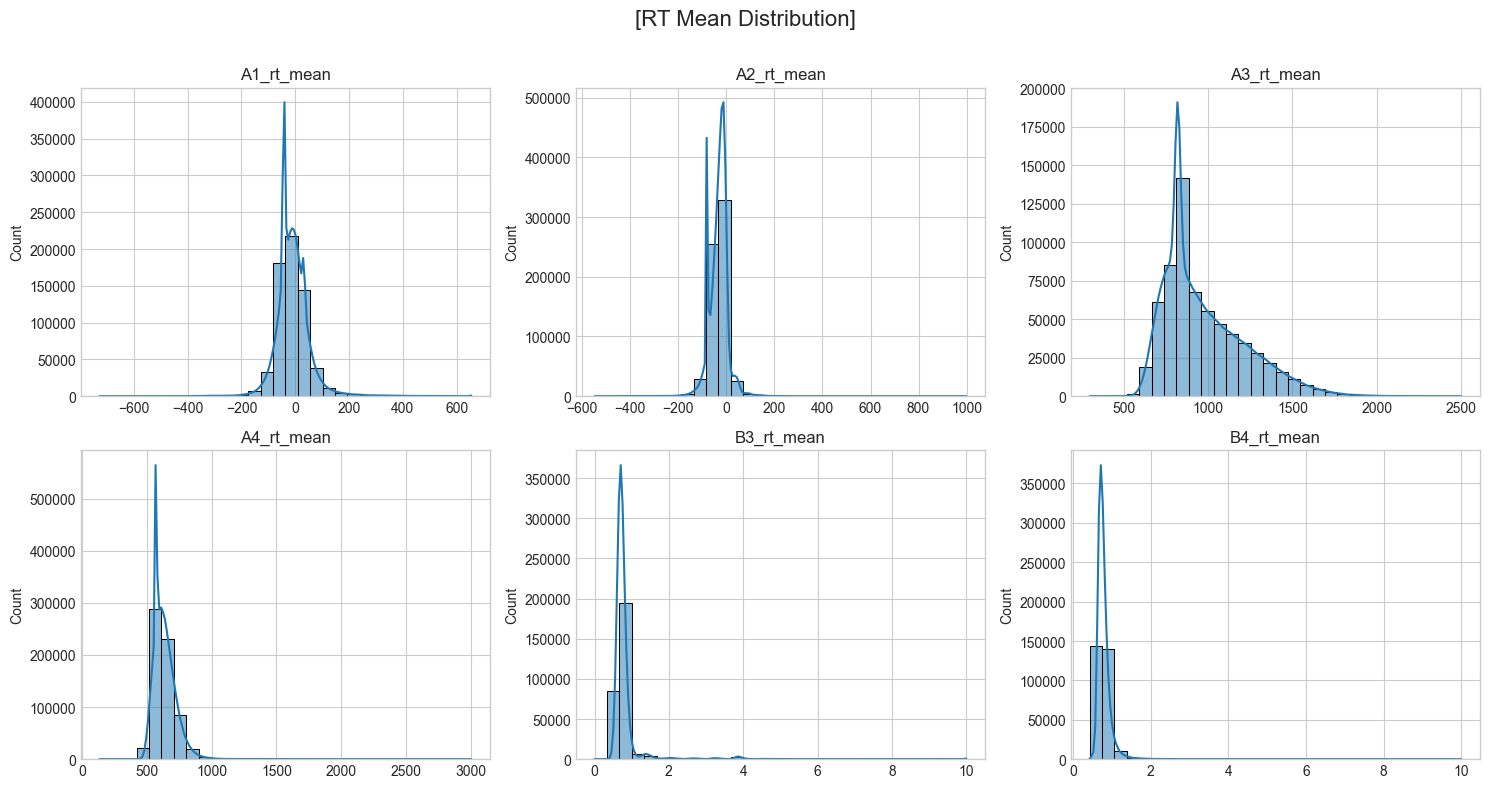

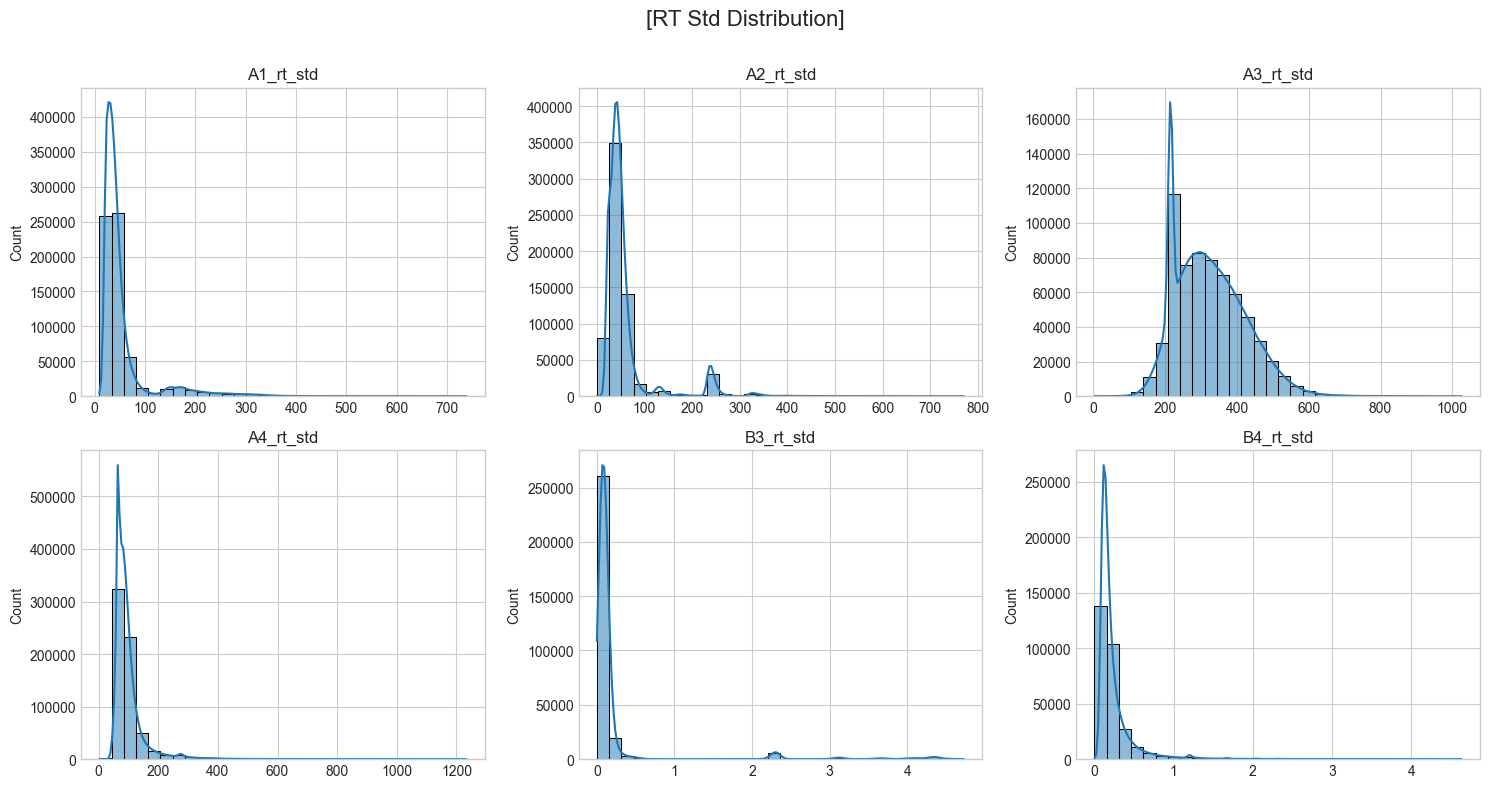

In [7]:
# ---------------------------- #
# 2) 히스토그램 + KDE 시각화
# ---------------------------- #
def plot_subplots(cols, title):
    n = len(cols)
    if n == 0:
        print(f"{title}: No columns found.")
        return
    
    # subplot grid 크기 자동 계산
    ncols = 3
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()  # 2D → 1D array

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.histplot(df[col].dropna(), bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")
    
    # 남는 subplot 숨기기
    for j in range(len(cols), len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

rt_mean_cols = [c for c in rt_cols if c.endswith("_rt_mean")]
rt_std_cols  = [c for c in rt_cols if c.endswith("_rt_std")]

print("RT mean 피처 수:", len(rt_mean_cols))
print("RT std 피처 수:", len(rt_std_cols))

plot_subplots(rt_mean_cols, "[RT Mean Distribution]")
plot_subplots(rt_std_cols,  "[RT Std Distribution]")

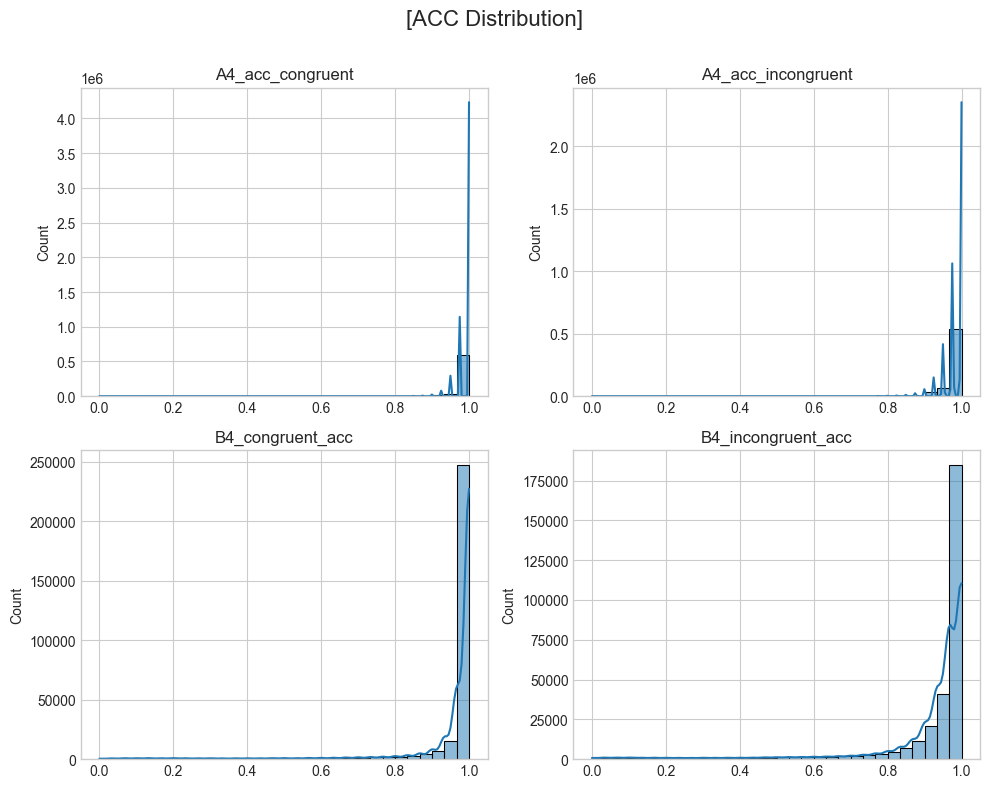

In [8]:
# ---------------------------- #
# 2) 히스토그램 + KDE 시각화
# ---------------------------- #
def acc_plot(cols, title):
    n = len(cols)
    if n == 0:
        print(f"{title}: No columns found.")
        return
    
    # subplot grid 크기 자동 계산
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()  # 2D → 1D array

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.histplot(df[col].dropna(), bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")
    
    # 남는 subplot 숨기기
    for j in range(len(cols), len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# ---------------------------- #
# 2) ACC 계열
# ---------------------------- #
acc_plot(acc_cols, "[ACC Distribution]")

#### 1-2. 이상치(outlier) 후보(극단적 반응시간, 지나치게 낮은 정확도)를 확인하여 전처리/모델링에서의 처리 방식을 검토

In [9]:
# ---------------------------- #
# 3) IQR 기반 이상치 후보 탐지
# ---------------------------- #
# IQR 기반 이상치 탐지 함수
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    mask = (series < lower) | (series > upper)
    outlier_idx = series[mask].index
    return lower, upper, len(outlier_idx), outlier_idx

rt_outlier_summary = []
acc_outlier_summary = []

# RT 컬럼 분석
for col in rt_cols:
    s = df[col].dropna()
    lower, upper, n_outliers, idx = detect_outliers(s)
    
    rt_outlier_summary.append({
        "feature": col,
        "lower_bound": lower,
        "upper_bound": upper,
        "n_outliers": n_outliers,
        "ratio(%)": round((n_outliers / len(s)) * 100, 4)
    })

# ACC 컬럼 분석
for col in acc_cols:
    s = df[col].dropna()
    lower, upper, n_outliers, idx = detect_outliers(s)
    
    acc_outlier_summary.append({
        "feature": col,
        "lower_bound": lower,
        "upper_bound": upper,
        "n_outliers": n_outliers,
        "ratio(%)": round((n_outliers / len(s)) * 100, 4)
    })

rt_outlier_df = pd.DataFrame(rt_outlier_summary)
acc_outlier_df = pd.DataFrame(acc_outlier_summary)

print("=== RT Outlier Summary ===")
display(rt_outlier_df.sort_values("n_outliers", ascending=False))

print("=== ACC Outlier Summary ===")
display(acc_outlier_df.sort_values("n_outliers", ascending=False))

=== RT Outlier Summary ===


,feature,lower_bound,upper_bound,n_outliers,ratio(%)
1,A1_rt_std,-6.498428,86.948303,67115,10.3694
3,A2_rt_std,-0.604272,91.403837,62446,9.6480
7,A4_rt_std,10.696968,162.240337,44303,6.8449
0,A1_rt_mean,-136.111111,114.555556,27960,4.3199
11,B4_rt_std,-0.089128,0.464343,27822,9.3512
9,B3_rt_std,-0.018269,0.197184,25630,8.6145
8,B3_rt_mean,0.450429,1.002130,17709,5.9521
2,A2_rt_mean,-123.472222,56.750000,15681,2.4227
10,B4_rt_mean,0.461833,1.065833,14118,4.7452
6,A4_rt_mean,410.018750,843.268750,13476,2.0821


=== ACC Outlier Summary ===


,feature,lower_bound,upper_bound,n_outliers,ratio(%)
1,A4_acc_incongruent,0.937500,1.0375,41325,6.3848
2,B4_congruent_acc,0.916667,1.0500,34654,11.6475
3,B4_incongruent_acc,0.833333,1.1000,32737,11.0032
0,A4_acc_congruent,0.937500,1.0375,13922,2.1510


C:\Users\cho03\AppData\Local\Temp\ipykernel_37040\2823064919.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\cho03\AppData\Local\Temp\ipykernel_37040\2823064919.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


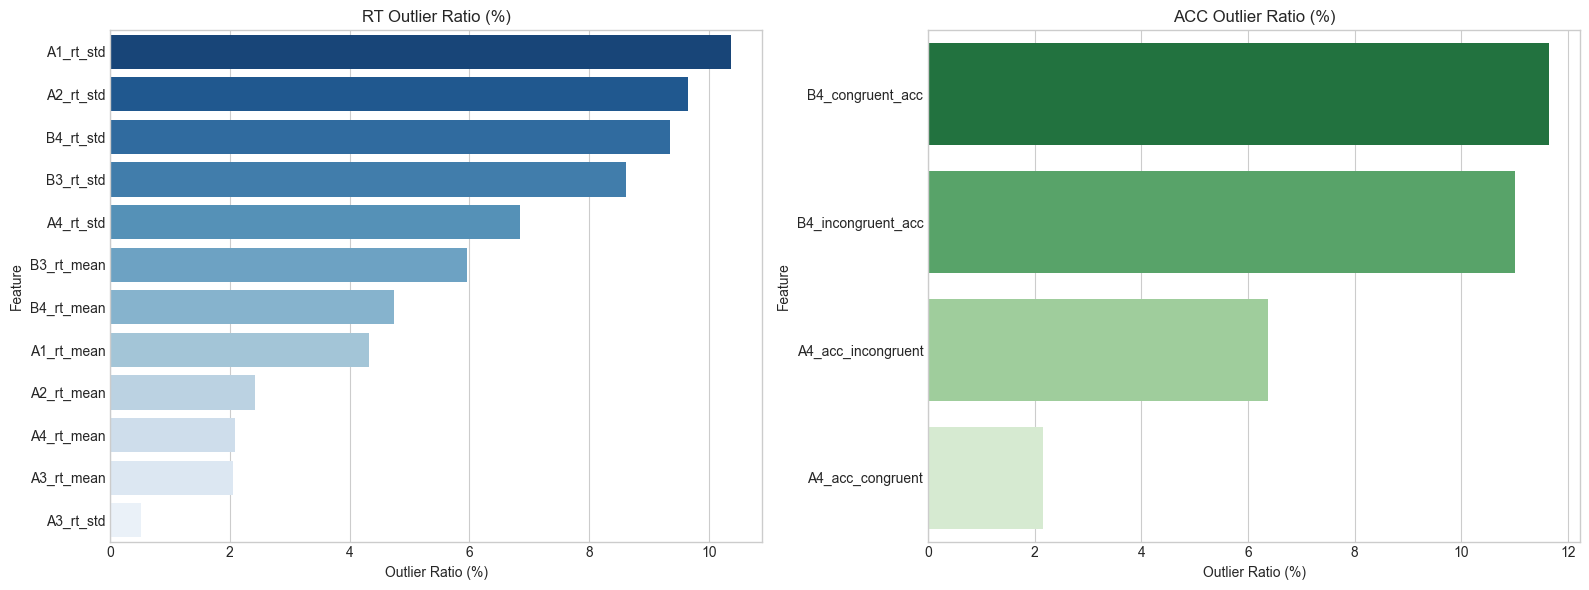

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# RT와 ACC의 outlier ratio 정렬
rt_ratio_sorted = rt_outlier_df.sort_values("ratio(%)", ascending=False)
acc_ratio_sorted = acc_outlier_df.sort_values("ratio(%)", ascending=False)

# 1x2 subplot 생성
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- (1) RT Outlier Ratio Plot ---
sns.barplot(
    data=rt_ratio_sorted,
    x="ratio(%)", y="feature",
    palette="Blues_r",
    ax=axes[0]
)
axes[0].set_title("RT Outlier Ratio (%)")
axes[0].set_xlabel("Outlier Ratio (%)")
axes[0].set_ylabel("Feature")

# --- (2) ACC Outlier Ratio Plot ---
sns.barplot(
    data=acc_ratio_sorted,
    x="ratio(%)", y="feature",
    palette="Greens_r",
    ax=axes[1]
)
axes[1].set_title("ACC Outlier Ratio (%)")
axes[1].set_xlabel("Outlier Ratio (%)")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()


### 2. 조건 간 차이 및 log-ratio

#### 2-1. Stroop/Flanker 계열
- 조건별 평균/정확도 차이 및 log-ratio(`A4_stroop_*`, `B4_flanker_*`)를 통해 간섭 효과 크기가 어느 정도 범위에서 움직이는지 확인

In [11]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

C:\Users\cho03\AppData\Local\Temp\ipykernel_37040\2971472721.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


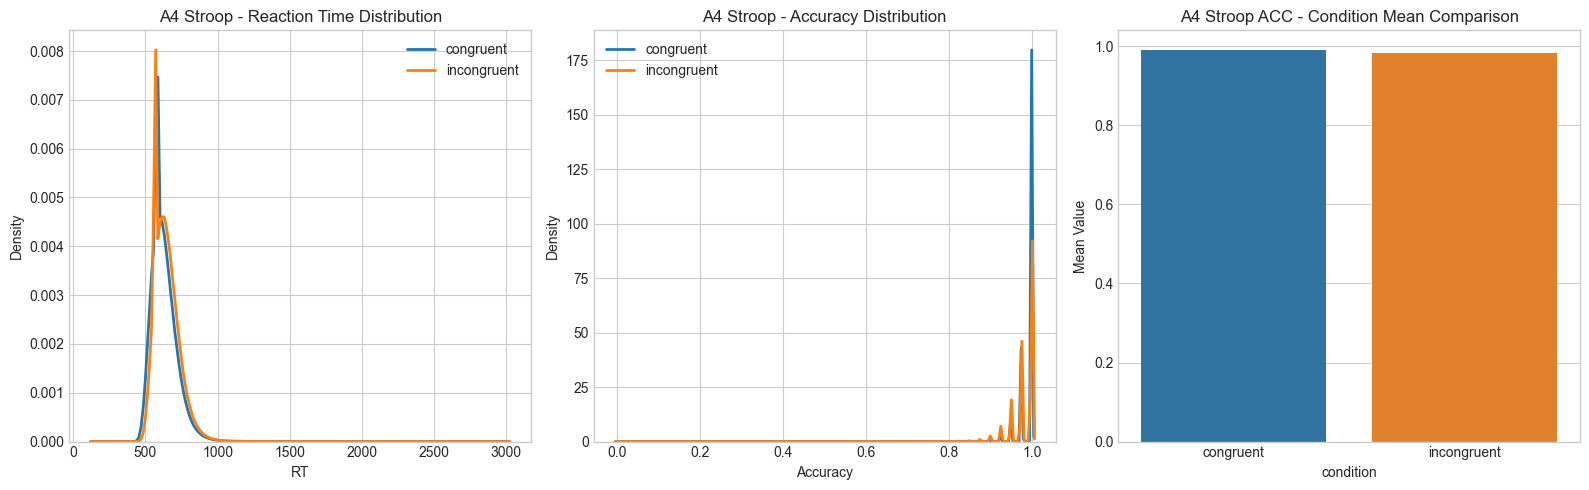

In [12]:
df = pd.read_feather("./data/all_train_data.feather")

# A/B 분리
df_A = df[df["Test_x"] == "A"].copy()
df_B = df[df["Test_x"] == "B"].copy()

# seaborn 기본 색상
blue = sns.color_palette()[0]     # 기본 파란색
orange = sns.color_palette()[1]   # 기본 주황색
green = sns.color_palette()[2]    # 기본 초록색
red = sns.color_palette()[3]      # 기본 빨간색
purple = sns.color_palette()[4]   # 기본 보라색
brown = sns.color_palette()[5]    # 기본 갈색

plt.figure(figsize=(16, 5))

# ---------------------------------------
# 1) Reaction Time KDE
# ---------------------------------------
plt.subplot(1, 3, 1)
sns.kdeplot(df_A["A4_rt_congruent"], label="congruent", linewidth=2, color=blue)
sns.kdeplot(df_A["A4_rt_incongruent"], label="incongruent", linewidth=2, color=orange)
plt.title("A4 Stroop - Reaction Time Distribution")
plt.xlabel("RT")
plt.legend()

# ---------------------------------------
# 2) Accuracy KDE
# ---------------------------------------
plt.subplot(1, 3, 2)
sns.kdeplot(df_A["A4_acc_congruent"], label="congruent", linewidth=2, color=blue)
sns.kdeplot(df_A["A4_acc_incongruent"], label="incongruent", linewidth=2, color=orange)
plt.title("A4 Stroop - Accuracy Distribution")
plt.xlabel("Accuracy")
plt.legend()

# ---------------------------------------
# 3) Barplot Mean Comparison
# ---------------------------------------
summary_stroop = pd.DataFrame({
    "condition": ["congruent", "incongruent"],
    "value": [
        df_A["A4_acc_congruent"].mean(),
        df_A["A4_acc_incongruent"].mean()
    ]
})

plt.subplot(1, 3, 3)
sns.barplot(
    data=summary_stroop,
    x="condition",
    y="value",
    palette=[blue, orange]   # seaborn 기본 색 사용
)
plt.title("A4 Stroop ACC - Condition Mean Comparison")
plt.ylabel("Mean Value")

plt.tight_layout()
plt.show()


C:\Users\cho03\AppData\Local\Temp\ipykernel_37040\3541140047.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_flanker, x="condition", y="value",  palette=[blue, orange])


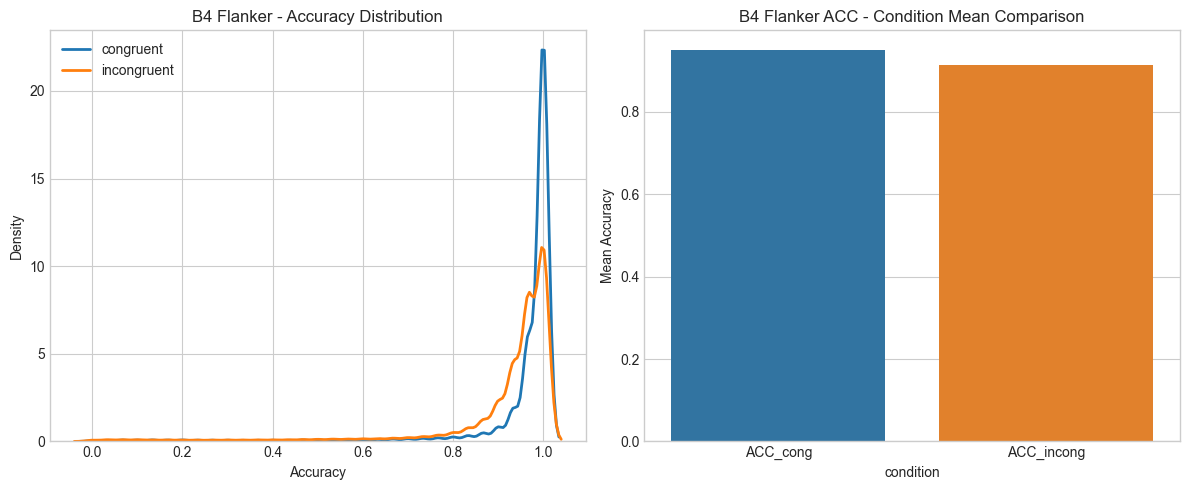

     condition     value
0    congruent  0.990402
1  incongruent  0.982077


In [13]:
# ---------------------------------------
# 5) 조건별 평균 차이를 barplot으로 시각화
# ---------------------------------------

summary_flanker = pd.DataFrame({
    "condition": ["ACC_cong", "ACC_incong"],
    "value": [
        df_B["B4_congruent_acc"].mean(),
        df_B["B4_incongruent_acc"].mean()
    ]
})

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
sns.kdeplot(df_B["B4_congruent_acc"], label="congruent", linewidth=2)
sns.kdeplot(df_B["B4_incongruent_acc"], label="incongruent", linewidth=2)
plt.title("B4 Flanker - Accuracy Distribution")
plt.xlabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
sns.barplot(data=summary_flanker, x="condition", y="value",  palette=[blue, orange])
plt.title("B4 Flanker ACC - Condition Mean Comparison")
plt.ylabel("Mean Accuracy")

plt.tight_layout()
plt.show()

print(summary_stroop)

#### 2-2. 주의 전환/시야각 계열
- A3_valid_acc vs A3_invalid_acc, B1/B2_change_acc vs nonchange_acc 등 조건별 난이도 차이가 일관되게 나타나는지 검토

In [14]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

C:\Users\cho03\AppData\Local\Temp\ipykernel_37040\3578767419.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_A3, x="condition", y="value", palette=[blue, orange])


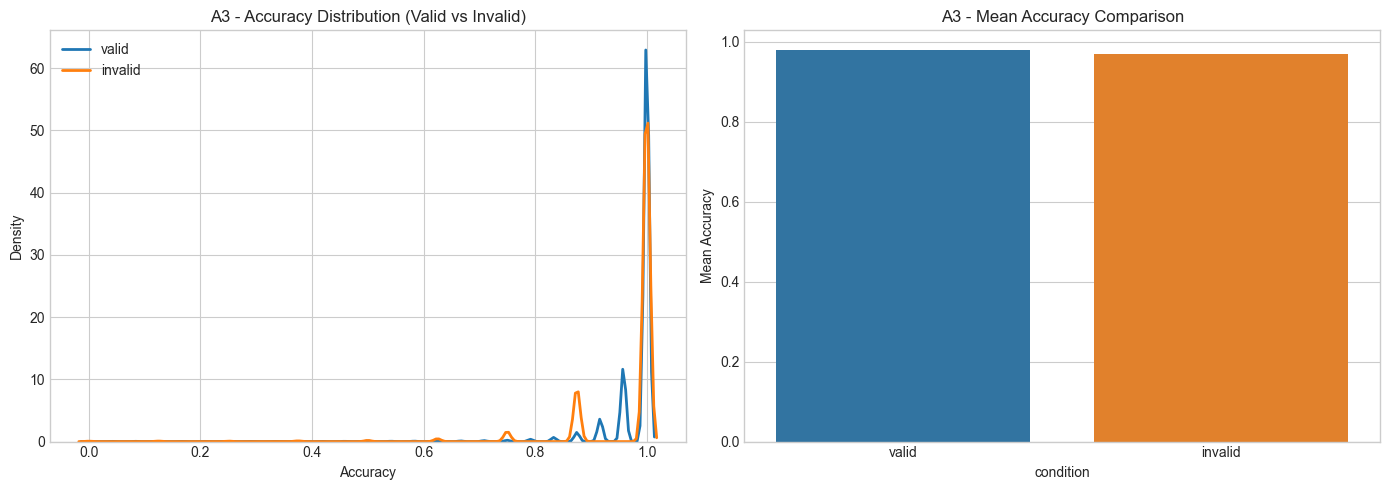

,condition,value
0,valid,0.979938
1,invalid,0.969545


In [15]:
df = pd.read_feather("./data/all_train_data.feather")

# A3 계열만 추출
df_A = df[df["Test_x"] == "A"].copy()

# -------------------------------
# 1) A3 valid vs invalid 정확도 비교
# -------------------------------

plt.figure(figsize=(14, 5))
# KDE
plt.subplot(1, 2, 1)
sns.kdeplot(df_A["A3_valid_acc"], label="valid", linewidth=2)
sns.kdeplot(df_A["A3_invalid_acc"], label="invalid", linewidth=2)
plt.title("A3 - Accuracy Distribution (Valid vs Invalid)")
plt.xlabel("Accuracy")
plt.legend()

# Mean barplot
summary_A3 = pd.DataFrame({
    "condition": ["valid", "invalid"],
    "value": [
        df_A["A3_valid_acc"].mean(),
        df_A["A3_invalid_acc"].mean()
    ]
})

plt.subplot(1, 2, 2)
sns.barplot(data=summary_A3, x="condition", y="value", palette=[blue, orange])
plt.title("A3 - Mean Accuracy Comparison")
plt.ylabel("Mean Accuracy")

plt.tight_layout()
plt.show()

summary_A3

C:\Users\cho03\AppData\Local\Temp\ipykernel_37040\2589741515.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_B1, x="condition", y="value", palette=[blue, orange])


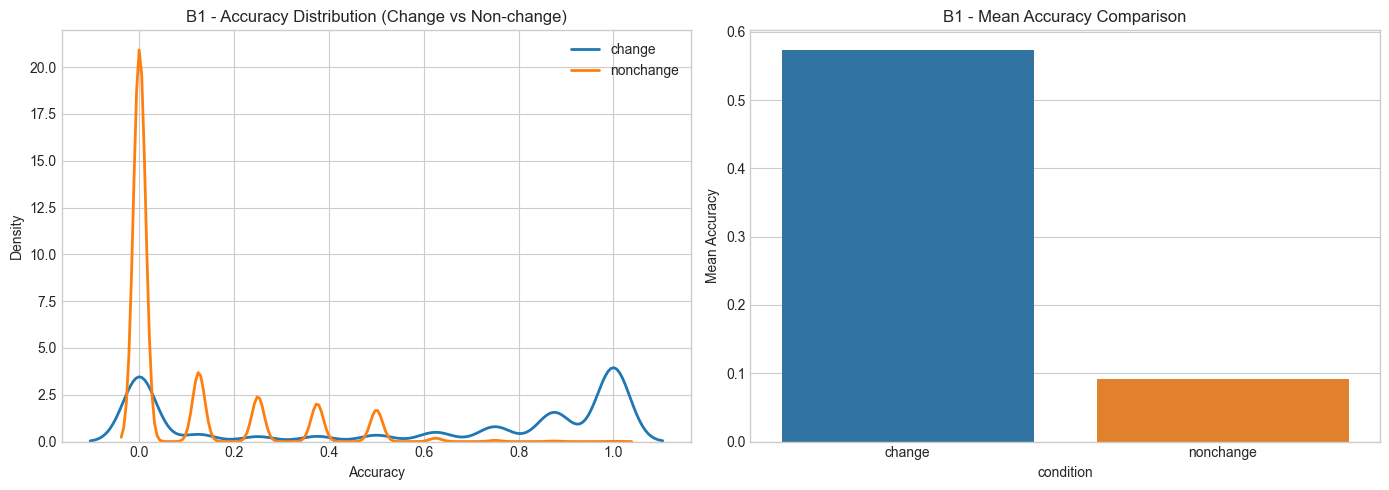

,condition,value
0,change,0.573291
1,nonchange,0.092351


In [16]:
# -------------------------------
# 2) B1 change vs non-change 정확도 비교
# -------------------------------

df_B = df[df["Test_x"] == "B"].copy()

plt.figure(figsize=(14, 5))

# KDE
plt.subplot(1, 2, 1)
sns.kdeplot(df_B["B1_change_acc"], label="change", linewidth=2)
sns.kdeplot(df_B["B1_nonchange_acc"], label="nonchange", linewidth=2)
plt.title("B1 - Accuracy Distribution (Change vs Non-change)")
plt.xlabel("Accuracy")
plt.legend()

# Mean barplot
summary_B1 = pd.DataFrame({
    "condition": ["change", "nonchange"],
    "value": [
        df_B["B1_change_acc"].mean(),
        df_B["B1_nonchange_acc"].mean()
    ]
})

plt.subplot(1, 2, 2)
sns.barplot(data=summary_B1, x="condition", y="value", palette=[blue, orange])
plt.title("B1 - Mean Accuracy Comparison")
plt.ylabel("Mean Accuracy")

plt.tight_layout()
plt.show()

summary_B1


C:\Users\cho03\AppData\Local\Temp\ipykernel_37040\2171734513.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_B2, x="condition", y="value", palette=[blue, orange])


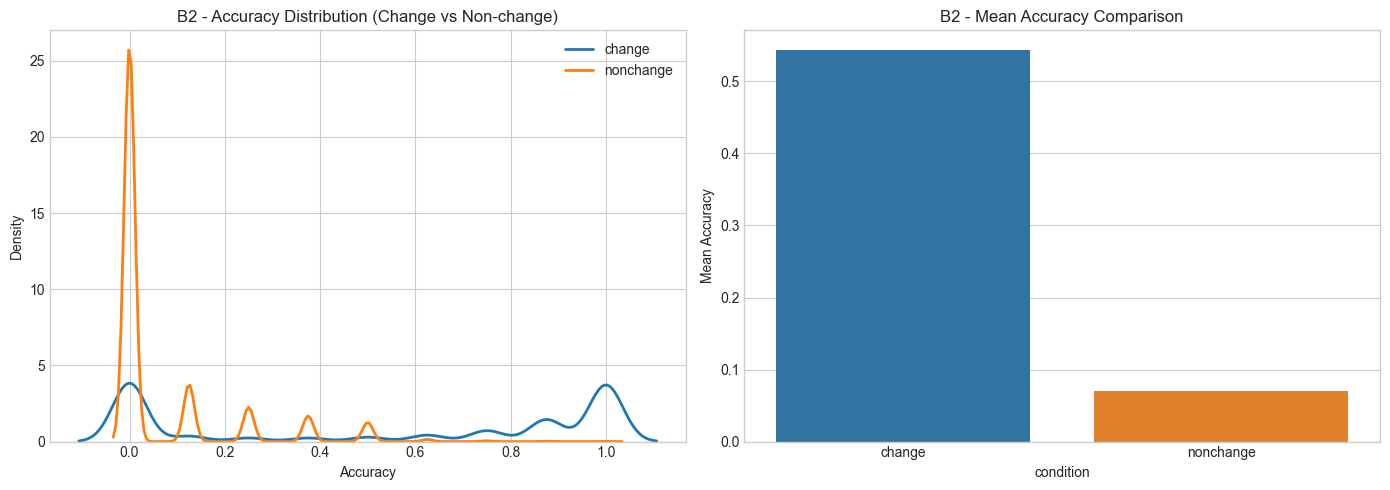

,condition,value
0,change,0.543579
1,nonchange,0.069847


In [17]:
# -------------------------------
# 3) B2 change vs non-change 정확도 비교
# -------------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(df_B["B2_change_acc"], label="change", linewidth=2)
sns.kdeplot(df_B["B2_nonchange_acc"], label="nonchange", linewidth=2)
plt.title("B2 - Accuracy Distribution (Change vs Non-change)")
plt.xlabel("Accuracy")
plt.legend()

summary_B2 = pd.DataFrame({
    "condition": ["change", "nonchange"],
    "value": [
        df_B["B2_change_acc"].mean(),
        df_B["B2_nonchange_acc"].mean()
    ]
})

plt.subplot(1, 2, 2)
sns.barplot(data=summary_B2, x="condition", y="value", palette=[blue, orange])
plt.title("B2 - Mean Accuracy Comparison")
plt.ylabel("Mean Accuracy")

plt.tight_layout()
plt.show()

summary_B2


### 3. Speed–Accuracy 및 CV
#### 3.1_speed_acc_tradeoff, *_rt_cv 분포를 통해 
- 빠른 대신 오류가 많은 유형 
- 느리지만 정확한 유형 등을 구분할 수 있는지, 값 범위가 안정적인지 확인

In [93]:
for i in df.columns:
    print(i)

Test_id
Test_x
Label
Test_y
PrimaryKey
Age
TestDate
Age_num
Year
Month
A1_rt_mean
A1_rt_std
A1_rt_left
A1_rt_right
A1_rt_slow
A1_rt_norm
A1_rt_fast
A1_acc_slow
A1_acc_norm
A1_acc_fast
A2_rt_mean
A2_rt_std
A2_rt_slow_c1
A2_rt_norm_c1
A2_rt_fast_c1
A2_rt_slow_c2
A2_rt_norm_c2
A2_rt_fast_c2
A2_acc_slow
A2_acc_norm
A2_acc_fast
A3_valid_acc
A3_invalid_acc
A3_rt_mean
A3_rt_std
A3_rt_small
A3_rt_big
A3_rt_left
A3_rt_right
A4_rt_mean
A4_rt_std
A4_rt_congruent
A4_rt_incongruent
A4_acc_congruent
A4_acc_incongruent
A5_acc_nonchange
A5_acc_pos_change
A5_acc_color_change
A5_acc_shape_change
A6_correct_count
A7_correct_count
YearMonthIndex
A1_speed_acc_tradeoff
A2_speed_acc_tradeoff
A4_speed_acc_tradeoff
A1_rt_cv
A2_rt_cv
A3_rt_cv
A4_rt_cv
A1_rt_speed_log_ratio
A1_acc_speed_log_ratio
A2_rt_speed_log_ratio_c1
A2_acc_speed_log_ratio
A3_rt_size_log_ratio
A3_acc_attention_log_ratio
A4_stroop_rt_log_ratio
A4_stroop_acc_log_ratio
A5_acc_pos_log_ratio
A5_acc_color_log_ratio
B1_task1_acc
B1_rt_mean
B1_rt_st

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화 스타일
sns.set(style="whitegrid", font_scale=1.2)

df = pd.read_feather("./data/all_train_data.feather")

# -------------------------------------------------------
# 공통: 속도-정확도 / CV 컬럼 추출
# -------------------------------------------------------
trade_cols = [c for c in df.columns if c.endswith("speed_acc_tradeoff")]
cv_cols     = [c for c in df.columns if c.endswith("_rt_cv")]

# -----------------------------
# 1) 주요 컬럼 추출
# -----------------------------
trade_cols_A = ["A1_speed_acc_tradeoff", "A2_speed_acc_tradeoff"]
trade_cols_B = ["B1_speed_acc_tradeoff", "B2_speed_acc_tradeoff"]

cv_cols_A = ["A1_rt_cv", "A2_rt_cv", "A3_rt_cv", "A4_rt_cv"]
cv_cols_B = ["B1_rt_cv", "B2_rt_cv", "B3_rt_cv", "B4_rt_cv", "B5_rt_cv"]

delta_trade_cols = [
    "delta_B1_speed_acc_tradeoff",
    "delta_B3_speed_acc_tradeoff"
]

# Summary Table 생성
summary_rows = []

for col in trade_cols + cv_cols:
    s = df[col].dropna()
    summary_rows.append({
        "feature": col,
        "count": len(s),
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "max": s.max(),
        "Q1": s.quantile(0.25),
        "Q3": s.quantile(0.75),
        "IQR": s.quantile(0.75) - s.quantile(0.25)
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

,feature,count,mean,std,min,max,Q1,Q3,IQR
0,A1_speed_acc_tradeoff,647241,-1.331064e+07,4.835090e+07,-3.929444e+08,3.728889e+08,-4.211111e+07,1.472222e+07,5.683333e+07
1,A2_speed_acc_tradeoff,647240,-3.266957e+07,3.419092e+07,-2.803333e+08,3.100556e+08,-5.400000e+07,-9.555556e+06,4.444444e+07
2,A4_speed_acc_tradeoff,647241,2.251844e+04,7.084239e+06,2.824419e+02,3.002075e+09,5.724869e+02,6.870993e+02,1.146124e+02
3,B1_speed_acc_tradeoff,297517,1.095050e+01,1.837801e+03,0.000000e+00,4.443498e+05,0.000000e+00,3.916633e-01,3.916633e-01
4,B2_speed_acc_tradeoff,297523,2.588879e+01,2.803113e+03,0.000000e+00,4.751422e+05,0.000000e+00,3.857908e-01,3.857908e-01
5,B3_speed_acc_tradeoff,297523,7.798617e+03,2.791355e+05,0.000000e+00,1.000000e+07,6.573277e-01,7.952693e-01,1.379415e-01
6,B4_speed_acc_tradeoff,297523,9.897653e+02,3.536053e+04,4.309996e-01,1.000000e+07,6.979993e-01,8.690553e-01,1.710560e-01
7,B5_speed_acc_tradeoff,297523,1.303350e+03,1.507950e+05,1.131998e+00,2.000000e+07,4.565258e+00,7.043992e+00,2.478733e+00
8,delta_B1_speed_acc_tradeoff,106245,4.336577e+00,2.580864e+03,-4.443495e+05,3.388976e+05,-6.123122e-02,1.653214e-01,2.265527e-01
9,delta_B2_speed_acc_tradeoff,106252,-2.506141e+01,4.029514e+03,-3.670325e+05,4.751422e+05,-6.573338e-02,1.711055e-01,2.368389e-01


In [20]:
# tradeoff 값(절댓값) 기준으로 큰 검사 상위 3개 찾기
# 1) tradeoff feature만 필터링
trade_summary = summary_df[summary_df["feature"].str.endswith("speed_acc_tradeoff")].copy()

# 2) 절댓값 기준으로 sort
trade_summary["abs_mean"] = trade_summary["mean"].abs()

top3_tradeoff = trade_summary.sort_values("abs_mean", ascending=False).head(3)

print("📌 Tradeoff 값이 가장 큰 검사 상위 3개")
display(top3_tradeoff[["feature", "mean", "abs_mean", "min", "max", "IQR"]])

📌 Tradeoff 값이 가장 큰 검사 상위 3개


,feature,mean,abs_mean,min,max,IQR
1,A2_speed_acc_tradeoff,-3.266957e+07,3.266957e+07,-2.803333e+08,3.100556e+08,4.444444e+07
0,A1_speed_acc_tradeoff,-1.331064e+07,1.331064e+07,-3.929444e+08,3.728889e+08,5.683333e+07
2,A4_speed_acc_tradeoff,2.251844e+04,2.251844e+04,2.824419e+02,3.002075e+09,1.146124e+02


In [21]:
# tradeoff가 가장 안정적인 검사(B 검사 중심) 찾기
# 1) B 검사 tradeoff만 추출
trade_B = trade_summary[trade_summary["feature"].str.startswith("B")].copy()

# 2) IQR 기준으로 안정적인(분산 작음) 순으로 정렬
stable_B = trade_B.sort_values("IQR", ascending=True).head(3)

print("📌 B 검사 중 tradeoff가 가장 안정적인 상위 3개 (IQR 기준)")
display(stable_B[["feature", "mean", "abs_mean", "min", "max", "IQR"]])

📌 B 검사 중 tradeoff가 가장 안정적인 상위 3개 (IQR 기준)


,feature,mean,abs_mean,min,max,IQR
5,B3_speed_acc_tradeoff,7798.617382,7798.617382,0.000,1.000000e+07,0.137942
6,B4_speed_acc_tradeoff,989.765309,989.765309,0.431,1.000000e+07,0.171056
4,B2_speed_acc_tradeoff,25.888790,25.888790,0.000,4.751422e+05,0.385791


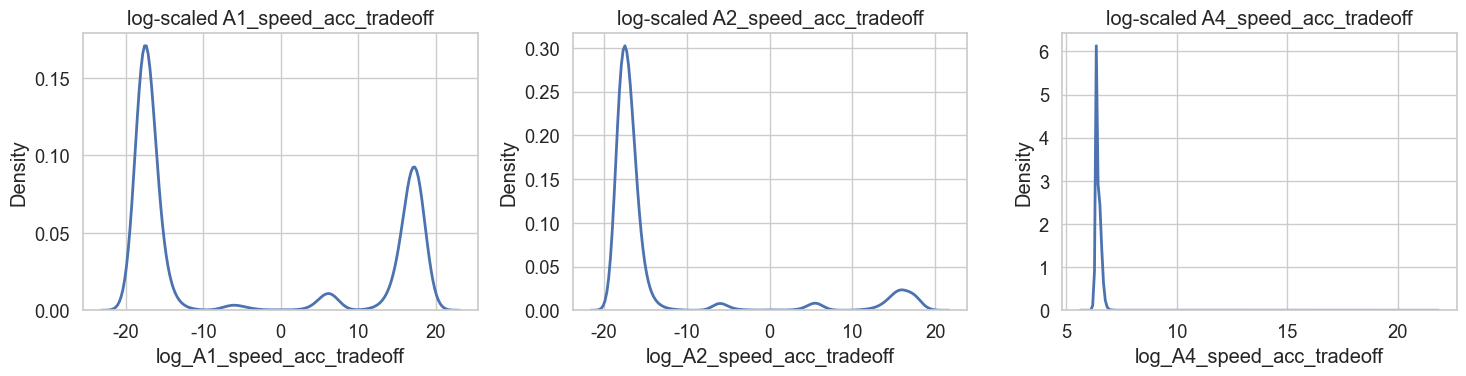

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)

df = pd.read_feather("./data/all_train_data.feather")

def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x))

# -------------------------
# speed_acc_tradeoff 대상
# -------------------------
trade_cols_A = [
    "A1_speed_acc_tradeoff",
    "A2_speed_acc_tradeoff",
    "A4_speed_acc_tradeoff",
]

df_A = df[df["Test_x"] == "A"].copy()

# log 변환
for col in trade_cols_A:
    df_A[f"log_{col}"] = signed_log1p(df_A[col])

# -------------------------
# speed_acc_tradeoff KDE만 시각화
# -------------------------
plt.figure(figsize=(15, 4))

for i, col in enumerate(trade_cols_A):
    log_col = f"log_{col}"
    s = df_A[log_col].dropna()

    ax = plt.subplot(1, 3, i + 1)
    sns.kdeplot(s, linewidth=2, ax=ax)
    ax.set_title(f"log-scaled {col}")

plt.tight_layout()
plt.show()


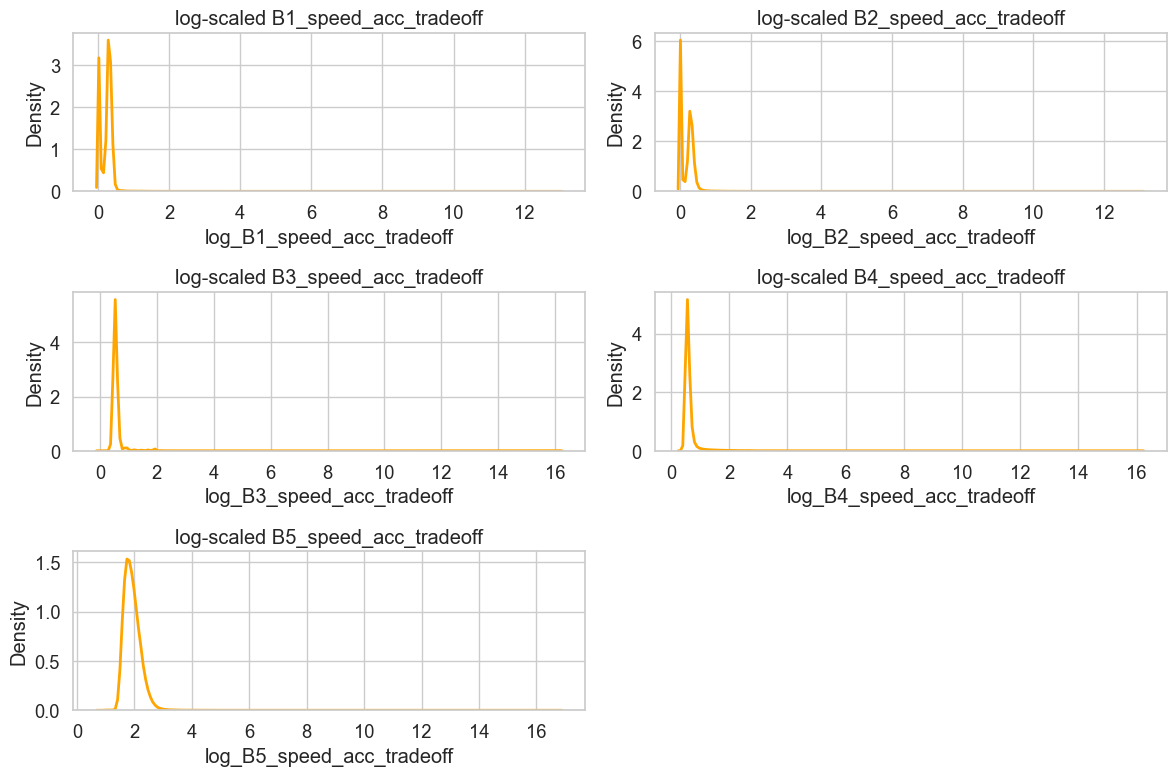

In [106]:
# -------------------------
# B검사: B1~B5 speed_acc_tradeoff KDE만 출력 (3×2 형태)
# -------------------------

trade_cols_B = [
    "B1_speed_acc_tradeoff",
    "B2_speed_acc_tradeoff",
    "B3_speed_acc_tradeoff",
    "B4_speed_acc_tradeoff",
    "B5_speed_acc_tradeoff",
]

df_B = df[df["Test_x"] == "B"].copy()

# log 변환
for col in trade_cols_B:
    df_B[f"log_{col}"] = signed_log1p(df_B[col])

# -------------------------
# 3×2 Plot
# -------------------------
plt.figure(figsize=(12, 8))

for i, col in enumerate(trade_cols_B):
    log_col = f"log_{col}"
    s = df_B[log_col].dropna()

    ax = plt.subplot(3, 2, i + 1)   # 3행 2열
    sns.kdeplot(s, linewidth=2, ax=ax, color="orange")
    ax.set_title(f"log-scaled {col}")

# 마지막 6번째 subplot은 비워둠
ax = plt.subplot(3, 2, 6)
ax.axis("off")

plt.tight_layout()
plt.show()


## 2. 히스토리·Delta·상관 분석

### 1. Delta(B-only)

#### 1-1. `delta_B*_…` 피처의 분포를 확인하여
- 평균적으로 변화가 0 근처에 몰려 있는지
- 특정 과제에서만 변화폭이 큰지 등을 파악하고, 노이즈로 볼 것인지 의미 있는 신호로 볼 것인지 판단

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)

# ----------------------------------------------------
# 1. 데이터 로드
# ----------------------------------------------------
df = pd.read_feather("./data/all_train_data.feather")
df_B = df[df["Test_x"] == "B"].copy()

delta_cols = [
    c for c in df.columns
    if c.startswith("delta_B") and c.endswith("rt_mean")
]

In [29]:
# ----------------------------------------------------
# 2. clipped mean(|delta|) 계산 함수
# ----------------------------------------------------
def clipped_mean_abs(series, q=0.005):
    lower = series.quantile(q)
    upper = series.quantile(1 - q)
    clipped = series.clip(lower, upper)
    return clipped.abs().mean()


In [30]:
# ----------------------------------------------------
# 3. Delta 분석 테이블 생성
# ----------------------------------------------------
records = []

for col in delta_cols:
    s = df_B[col].dropna()
    records.append({
        "feature": col,
        "mean_abs_clipped": clipped_mean_abs(s),
        "near_zero_ratio": (s.abs() < 0.01).mean()
    })

delta_summary = pd.DataFrame(records).set_index("feature")

print("\n[Delta Summary Preview]")
display(delta_summary.head())


[Delta Summary Preview]


,mean_abs_clipped,near_zero_ratio
feature,,
delta_B1_rt_mean,0.147940,0.201939
delta_B2_rt_mean,0.137418,0.238170
delta_B3_rt_mean,0.191319,0.101551
delta_B4_rt_mean,0.102636,0.095970
delta_B5_rt_mean,0.997674,0.007925


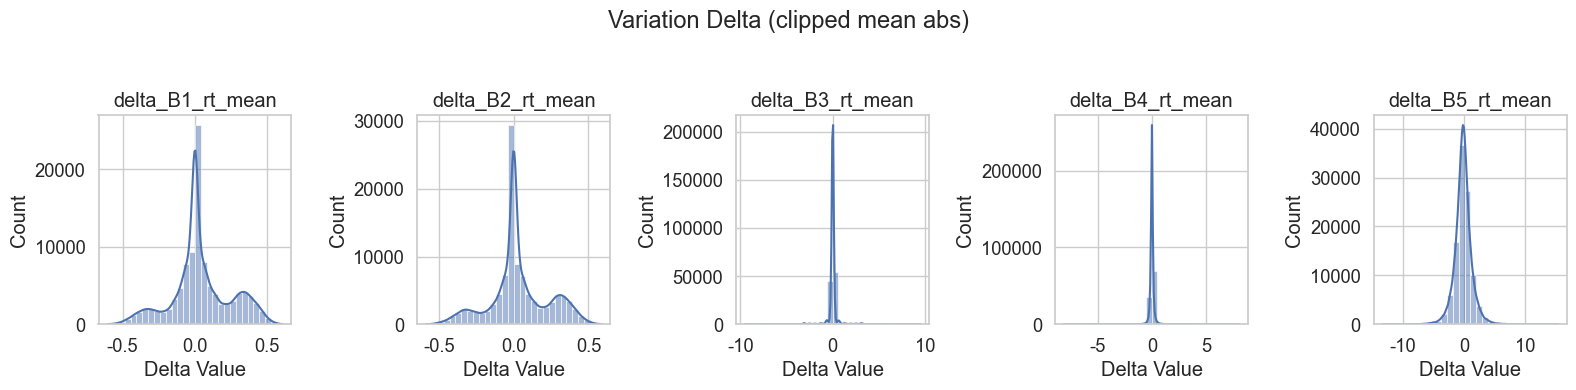

In [31]:
# ----------------------------------------------------
# 4. plot 그리기
# ----------------------------------------------------
def plot_row_subplot(cols, title):
    fig, axes = plt.subplots(1, len(cols), figsize=(16, 4))

    for ax, col in zip(axes, cols):
        sns.histplot(df_B[col].dropna(), bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("Delta Value")
    
    plt.suptitle(title, fontsize=17)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


# 변화량 plot
plot_row_subplot(delta_cols, "Variation Delta (clipped mean abs)")

#### 1-2. 특정 과제에서만 변화폭이 큰지 등을 파악하고, 노이즈로 볼 것인지 의미 있는 신호로 볼 것인지 판단


In [32]:
df_B = df[df["Test_x"] == "B"].copy()

delta_cols = [
    c for c in df.columns
    if c.startswith("delta_B") and c.endswith("rt_mean")
]

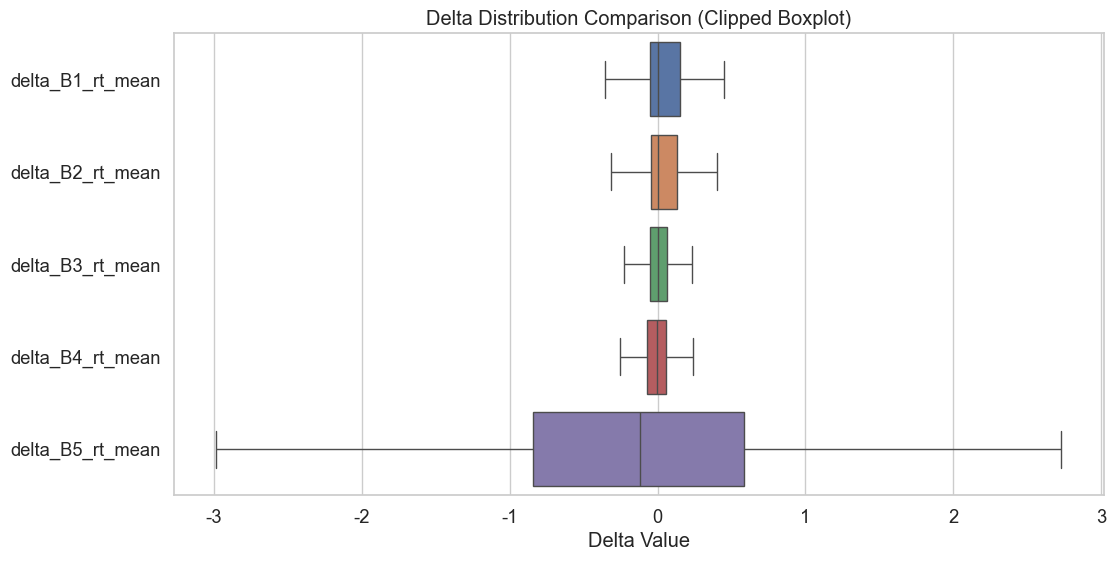

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# delta 컬럼 clipping (0.5% ~ 99.5% 범위만 사용)
df_delta_clipped = df_B.copy()

for col in delta_cols:
    q_low = df_delta_clipped[col].quantile(0.005)
    q_high = df_delta_clipped[col].quantile(0.995)
    df_delta_clipped[col] = df_delta_clipped[col].clip(q_low, q_high)

# clipped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_delta_clipped[delta_cols], orient="h", showfliers=False)
plt.title("Delta Distribution Comparison (Clipped Boxplot)")
plt.xlabel("Delta Value")
plt.show()


### 2. 상관 구조

#### 2-1. 반응시간·정확도·log-ratio·히스토리·Delta 피처 간 상관계수 행렬을 통해 피처 그룹 간 중복/보완 관계를 파악

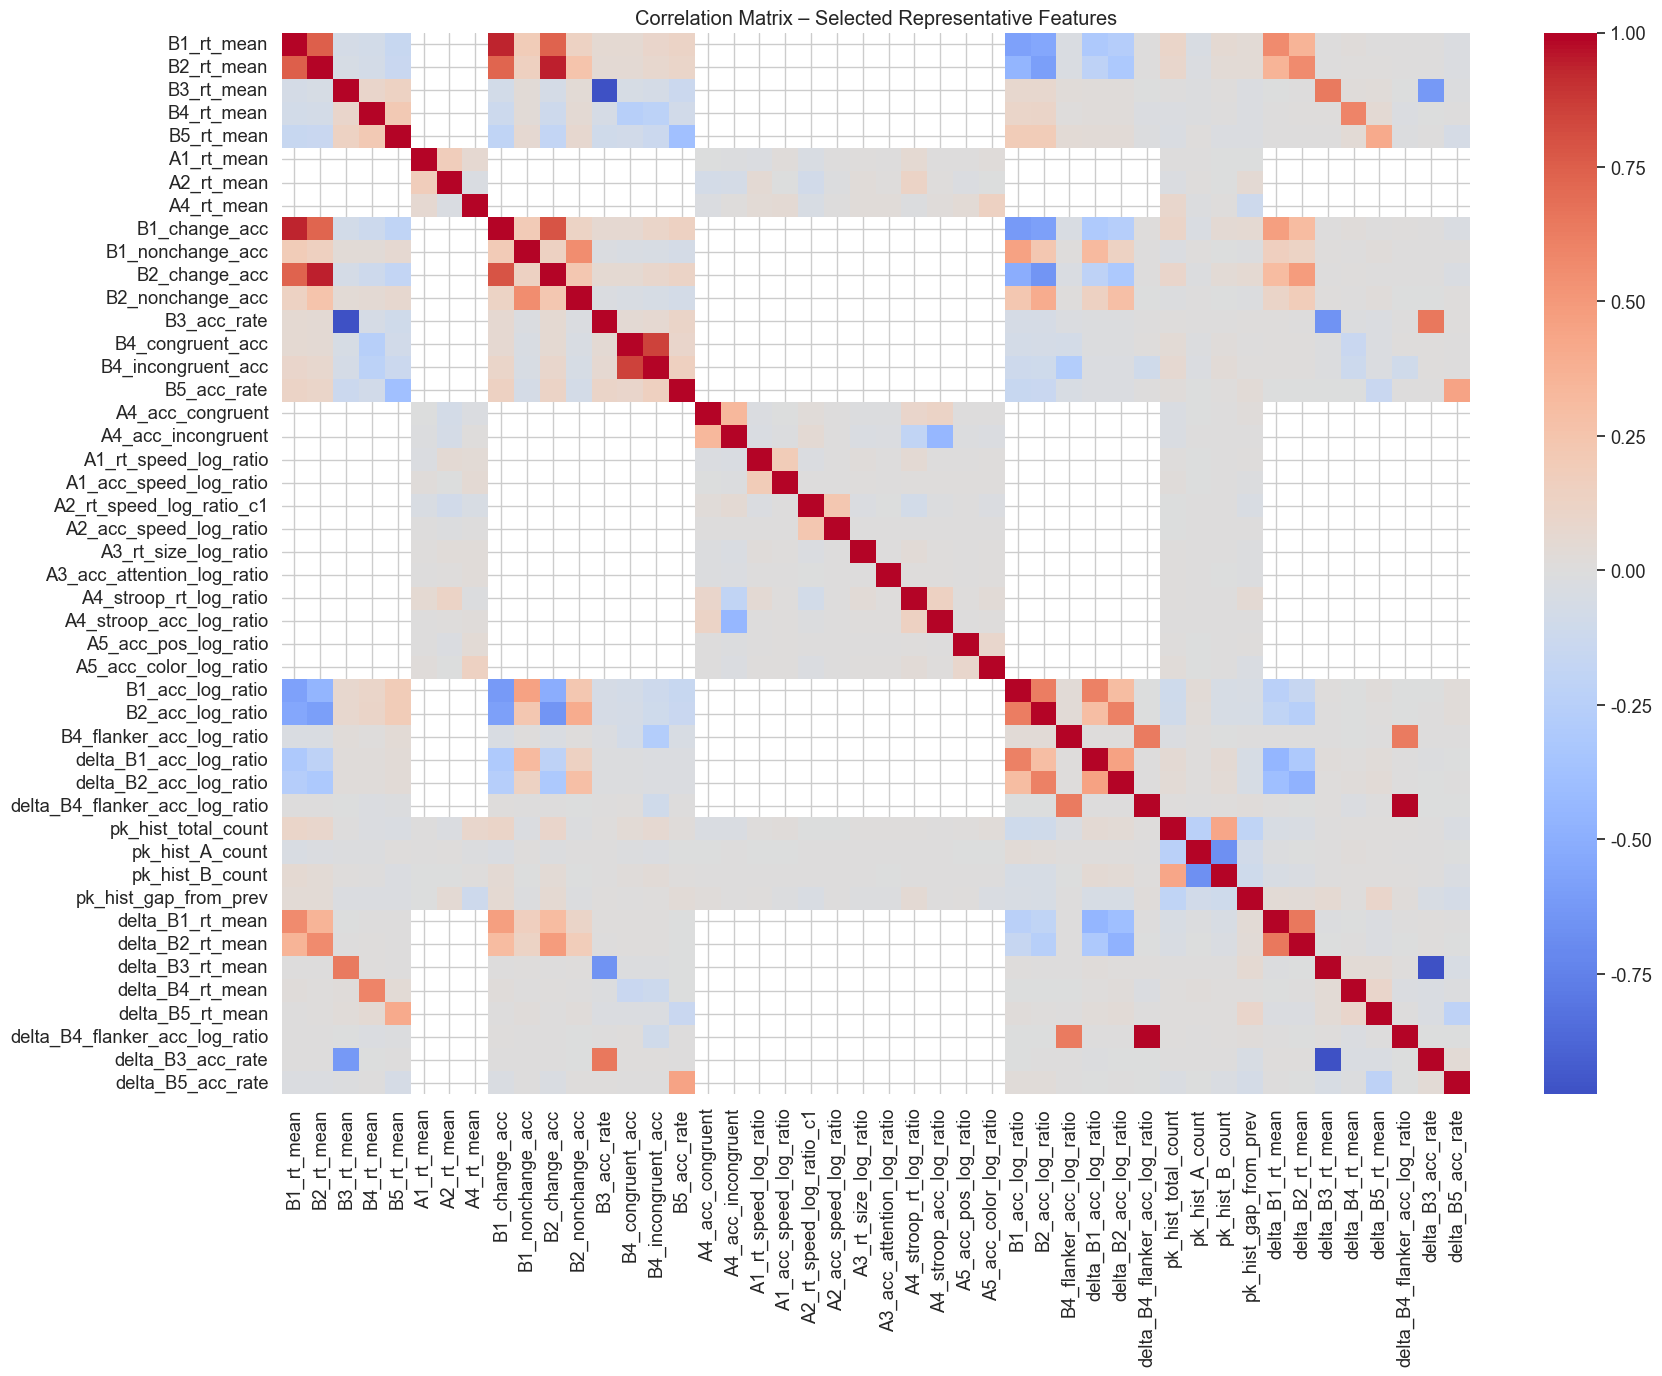

In [83]:
# --- 선택된 대표 피처들 ---
use_RT = [
    "B1_rt_mean","B2_rt_mean","B3_rt_mean","B4_rt_mean","B5_rt_mean",
    "A1_rt_mean","A2_rt_mean","A4_rt_mean"
]

use_ACC = [
    "B1_change_acc","B1_nonchange_acc",
    "B2_change_acc","B2_nonchange_acc",
    "B3_acc_rate",
    "B4_congruent_acc","B4_incongruent_acc",
    "B5_acc_rate",
    "A4_acc_congruent","A4_acc_incongruent"
]

logratio_cols = [c for c in df.columns if "log_ratio" in c]
use_LOGRATIO = logratio_cols

use_HIST = [
    "pk_hist_total_count","pk_hist_A_count","pk_hist_B_count","pk_hist_gap_from_prev"
]

use_DELTA = [
    "delta_B1_rt_mean","delta_B2_rt_mean","delta_B3_rt_mean",
    "delta_B4_rt_mean","delta_B5_rt_mean",
    "delta_B4_flanker_acc_log_ratio",
    "delta_B3_acc_rate","delta_B5_acc_rate"
]

selected = use_RT + use_ACC + use_LOGRATIO + use_HIST + use_DELTA

# 상관행렬 계산
corr = df[selected].corr()

# 시각화
plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix – Selected Representative Features")
plt.tight_layout()
plt.show()

In [88]:
# 피처 중복도(VIF: Variance Inflation Factor) 계산 코드 : 다른 피처로 설명되는 정도(중복성)를 측정 → 10 이상이면 강한 다중공선성.
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif_safe(df, cols):
    # 1) 수치형 컬럼만 남김
    X = df[cols].select_dtypes(include=[np.number]).copy()

    # 2) 전부 NaN인 컬럼 제거
    X = X.dropna(axis=1, how="all")

    # 3) nunique가 scalar일 때만 처리 → 상수 컬럼 제거
    drop_cols = []
    for c in X.columns:
        try:
            uniq = X[c].nunique(dropna=True)
            if uniq <= 1:
                drop_cols.append(c)
        except:
            drop_cols.append(c)  # nunique가 문제 발생 시 제거

    if drop_cols:
        print("상수 또는 비정상 컬럼 제거:", drop_cols)
        X = X.drop(columns=drop_cols)

    # 4) 결측 제거 (VIF 계산 위해)
    X = X.dropna()
    if X.shape[0] == 0:
        print("VIF 계산 불가: 남은 데이터 없음")
        return None

    # 5) 분산 0인 컬럼 제거
    zero_var = [c for c in X.columns if X[c].var() == 0]
    if zero_var:
        print("분산 0 컬럼 제거:", zero_var)
        X = X.drop(columns=zero_var)

    if X.shape[1] <= 1:
        print("VIF 계산 불가: feature 1개 이하")
        return None

    # 6) 실제 VIF 계산
    X_const = sm.add_constant(X)
    vif_values = []

    for i in range(1, X_const.shape[1]):  # 0은 constant
        vif = variance_inflation_factor(X_const.values, i)
        vif_values.append(vif)

    return pd.DataFrame({
        "feature": X.columns,
        "VIF": vif_values
    }).sort_values("VIF", ascending=False)



In [90]:
dfA = df[df["Test_x"]=="A"].copy()
dfB = df[df["Test_x"]=="B"].copy()

A_cols = [c for c in selected if c in dfA.columns]
B_cols = [c for c in selected if c in dfB.columns]

print("\n[A VIF]")
vif_A = compute_vif_safe(dfA, A_cols)
print(vif_A)

print("\n[B VIF]")
vif_B = compute_vif_safe(dfB, B_cols)
print(vif_B)


[A VIF]


d:\대학원\공모전\Dacon\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                       feature       VIF
16             pk_hist_A_count       inf
15         pk_hist_total_count       inf
17             pk_hist_B_count       inf
4           A4_acc_incongruent  6.409639
12     A4_stroop_acc_log_ratio  4.841451
3             A4_acc_congruent  3.119319
2                   A4_rt_mean  1.132411
11      A4_stroop_rt_log_ratio  1.106200
7     A2_rt_speed_log_ratio_c1  1.088650
1                   A2_rt_mean  1.069411
8       A2_acc_speed_log_ratio  1.067806
6       A1_acc_speed_log_ratio  1.048053
18       pk_hist_gap_from_prev  1.043582
5        A1_rt_speed_log_ratio  1.041939
14      A5_acc_color_log_ratio  1.035536
0                   A1_rt_mean  1.034156
13        A5_acc_pos_log_ratio  1.020972
9         A3_rt_size_log_ratio  1.007971
10  A3_acc_attention_log_ratio  1.001923

[B VIF]
상수 또는 비정상 컬럼 제거: ['delta_B4_flanker_acc_log_ratio', 'delta_B4_flanker_acc_log_ratio']


d:\대학원\공모전\Dacon\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                     feature        VIF
19           pk_hist_A_count        inf
20           pk_hist_B_count        inf
18       pk_hist_total_count        inf
9                B3_acc_rate  31.135509
2                 B3_rt_mean  30.903704
24          delta_B3_rt_mean  22.449763
27         delta_B3_acc_rate  22.337217
7              B2_change_acc  16.533574
1                 B2_rt_mean  15.371368
5              B1_change_acc  14.646567
0                 B1_rt_mean  13.561734
14          B2_acc_log_ratio   6.346048
13          B1_acc_log_ratio   5.948051
11        B4_incongruent_acc   4.447535
10          B4_congruent_acc   4.178088
22          delta_B1_rt_mean   3.579033
23          delta_B2_rt_mean   3.479199
6           B1_nonchange_acc   3.045459
8           B2_nonchange_acc   2.906057
17    delta_B2_acc_log_ratio   2.866437
16    delta_B1_acc_log_ratio   2.747758
3                 B4_rt_mean   1.793117
4                 B5_rt_mean   1.666246
25          delta_B4_rt_mean   1.621129


#### 2-2. 트리 기반 모델의 특성상 강한 상관이 존재해도 필수적으로 제거하지는 않되, 도메인 해석이 불명확한 피처는 중요도가 낮을 경우 정리 대상 후보로 고려